# Simulating a Rural Community Load Profile with RAMP 

RAMP is an open-source software designed for the generation of **high-resolution multi-energy profiles** where only rudimentary information on user behaviour is available, allowing for the **characterization of users**, **appliances** and the definition of **operating windows**, to yield a finely detailed energy usage profile on a **minute basis**.

<div style="text-align: center;">
  <img src="Images/RAMP_intro.png" alt="Examples of load curve demands estimated using RAMP software" style="width:80%;"/>
</div>

In the following sections of this notebook, you will learn how to use the RAMP tool for simulating electrical load profiles by uploading data in an Excel file format. The process is outlined step by step below to facilitate easy navigation and execution.

- **Step 1 - Upload Excel File**: Select and upload the Excel file containing your input data, which should include detailed information on appliance usage,  and other parameters necessary for the simulation. More info in the next paragraph. 
- **Step 2 - Set Simulation Parameters**: Determine the simulation period by setting the number of different days (profiles) to be generated. Press the `Generate Profiles` button to start the simulation process.
- **Step 3 - Review Results**: View the simulation results displayed in this notebook once the computation is complete. The output includes daily and cumulative load profiles, illustrating the energy consumption patterns across different user categories specified in your Excel file.
- **Step 4 - Exporting the Results**: Export the simulation results, including daily load profiles and average daily load, into an Excel file named *Load demand results.xlsx*, located in the *Jupyter Notebooks/Results* folder.


## Excel File Structure

The Excel file serves as the input for the RAMP simulation, providing detailed specifications for each user group within the community and their corresponding appliance usage. The structure of the input Excel file is shown in the figure below:

<div style="text-align: center;">
  <img src="Images/Excel_structure.png" alt="Examples of load curve demands estimated using RAMP software" style="width:80%;"/>
</div>

The Excel file designed for input into the RAMP simulation tool systematically captures the details of energy usage for different demographic user groups and their respective appliances. Below is the structural organization of the Excel file:

### Rows: Representation of Appliance Usage by User Groups

- Each row corresponds to an appliance usage profile linked to a specific user category.
- Rows are categorized by user_name, representing different groups such as income levels or specific sectors (residential, commercial, educational, etc.).

### Columns: Parameters Detailing User and Appliance Information

- **User**: Associates the appliance with a specific user class in the RAMP model.
- **Number**: Indicates how many units of the appliance are present, defaulting to 1 if not specified.
- **Power**: Represents the energy consumption rate of the appliance, either as a constant value or a variable series across days (e.g., average in Watts). Default is 0.
- **Number of Windows**: Specifies the count of distinct time windows within which the appliance operates, default is 1.
- **Functional Time**: Total operational time of the appliance per day, measured in minutes from 0 to 1440, default is 0.
- **Time Fraction Random Variability**: Percentage of the total operational time that exhibits random variability, default is 0%.
- **Functional Cycle**: Minimum continuous operating time once the appliance is turned on, measured in minutes, default is 1 minute.
- **Fixed**: Indicates if all units of the appliance always switch on simultaneously ('yes') or independently ('no'), default is "no".
- **Fixed Cycle**: Defines the number of operational cycles, where 0 indicates continuous operation. Non-zero values require specifying cycle windows (up to 3), default is 0.
- **Occasional Use**: Percentage indicating how frequently the appliance is used, with 1.0 meaning daily use and lower values reflecting less frequent use, default is 1.
- **Flat**: Whether the appliance is subject to any random variability ('no') or not ('yes'), applicable to devices like public lighting, default is "no".
- **Thermal Power Variability**: Percentage variability in power usage due to factors like temperature changes, default is 0%.
- **Preference Index**: A numerical index used to associate the appliance with user's daily preference patterns, must be equal to or less than the max value specified in user preferences, default is 0.
- **Weekday/Weekend Type**: Specifies appliance use as weekdays (0), weekends (1), or both (2), default is 2.

### Tips for Filling Out the Excel File

- Reflect the structure of your specific community by accurately representing each user group along with their appliances in the rows.
- Complete the columns with the necessary parameters to describe the operational profile and characteristics of these appliances.
- Ensure data uniformity in terms of units and formatting to facilitate the correct processing by the simulation totions.

<div style="background-color: #FFCCCC; border-left: 6px solid #FF0000; padding: 10px; margin-bottom: 20px;">
    <strong>Warning:</strong> The code blocks below are delicate as they define critical functions for pre-processing and initializing the use case. Please do <strong>NOT</strong> modify this code unless you are familiar with its structure and dependencies. Run it and interact with the subsequent widgets to customize your input parameters and trigger simulations.
</div>

## Initialization

In the code cell below, we initialize an interactive widget to upload the Excel file required for the RAMP simulation. Please select your .xlsx file and upload it to proceed with the simulation.

In [79]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create the uploader widget
uploader = widgets.FileUpload(
    accept='.xlsx',  # Accept .xlsx files only
    multiple=False,  # Only single file uploads allowed
    description='Upload your file'
)

# Create a button for the user to click after uploading to verify the file upload
verify_upload_button = widgets.Button(description="Verify Upload")

# Output widget to display messages
output = widgets.Output()

# Define a function to be called when the verify upload button is clicked
def verify_upload(b):
    with output:
        clear_output()  # Clear previous output
        if uploader.value:
            # Access uploader.value, which is a tuple of dictionaries
            uploaded_files = uploader.value
            # Iterate over each file's dictionary
            for file_info in uploaded_files:
                file_name = file_info['name']
                last_modified = file_info['last_modified']
                print(f"\nFile successfully uploaded: {file_name}, last modified: {last_modified}")
        else:
            print("No file has been uploaded. Please try again.")

# Attach the function to the button's on_click event
verify_upload_button.on_click(verify_upload)

# Use HBox to place the upload and verify buttons side by side
buttons = widgets.HBox([uploader, verify_upload_button])

# Display the buttons and the output area
print("Please upload the Excel Input file (.xlsx) and then click 'Verify Upload' to check the file:\n")
display(buttons, output)

Please upload the Excel Input file (.xlsx) and then click 'Verify Upload' to check the file:



Output()

## Profile Simulation

Once you have uploaded the Excel file, run the cell below to set up an interactive simulation environment. Start by selecting the number of days for the simulation period using the provided input widget. After setting the number of days, click the "Generate Profiles" button to initiate the simulation process. This simulation utilizes parallel processing to efficiently generate daily load profiles, significantly enhancing performance for extensive datasets.

During the simulation, a progress bar will appear, giving you a visual indication of the ongoing process. Depending on the number of days you have chosen, the simulation can take several minutes to complete. Please refrain from proceeding to subsequent cells until you see the message "Load Profiles successfully generated." appear in the output area, indicating that the simulation has been completed successfully. This ensures that all profiles are fully prepared before moving forward with any further analysis or steps.

In [80]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from io import BytesIO
from ramp import UseCase

# Global variable to store the load profile
load_profile = None

# Widgets for selecting number of days
num_days_input = widgets.IntText(description='Number', value=365)

# Button to trigger simulation
run_button = widgets.Button(description="Generate Profiles")
output_area = widgets.Output()

def run_usecase(num_days, force_reinitialize=False):
    global load_profile
    try:
        first_uploaded_file = next(iter(uploader.value))
        file_content = BytesIO(first_uploaded_file['content'])
        
        usecase = UseCase(name="Use Case")
        # Use force=True if reinitialization is needed
        usecase.initialize(num_days=num_days, force=force_reinitialize)
        usecase.load(file_content)  # Load data from file content

        load_profile = usecase.generate_daily_load_profiles()
        return "\nLoad Profiles successfully generated."

    except Exception as e:
        return f"An error occurred: {str(e)}"

def on_button_clicked(b):
    with output_area:
        clear_output()
        num_days = num_days_input.value
        force_reinit = True  # Example: setting it True for demonstration
        print("Generating load profiles, please wait...\n")
        result_message = run_usecase(num_days, force_reinitialize=force_reinit)
        print(result_message)

run_button.on_click(on_button_clicked)

# Display widgets and output area
print("\nSelect the number of days for the simulation period:\n")
display(num_days_input)
print("\nClick 'Generate Profiles' to start the simulation and wait for the confirmation message.\n")
display(run_button, output_area)


Select the number of days for the simulation period:



IntText(value=365, description='Number')


Click 'Generate Profiles' to start the simulation and wait for the confirmation message.



Button(description='Generate Profiles', style=ButtonStyle())

Output()

## Visualizing Results

### Daily Average Load Curve - Minute Resolution

The following cell is dedicated to the post-processing of the generated load profiles. It starts by importing the necessary modules and a function for formatting the profiles. Then, it reshapes the profile data into a daily format and calculates statistical values such as the average, minimum, and maximum for each day. Following these calculations, there are two functions:

- *plot_cloud_plot_with_avg*: This function visualizes the range of daily profiles, displaying a cloud plot with the average daily profile highlighted.
- *calculate_average_profile_metrics*: This function computes the average daily energy consumption and the peak power from the average profile.
- *plot_cloud_plot_with_avg*: This function generates a plot that not only visualizes the average daily load curve but also highlights the range of variability across the simulated days, providing a comprehensive overview of the power usage patterns.

Make sure the simulation and data processing from previous cells are complete before running this cell. After executing, you will see a plot displaying the cloud of daily load profiles along with the average daily load. This visualization provides insights into the variability and average consumption patterns of the simulated load demand. The plot would also be saved within Jupyter Notebooks/Results folder.

In [ ]:
# Importing post-processing functions
from ramp.post_process.post_process import Profile_formatting
import numpy as np
import matplotlib.pyplot as plt

# Formatting the profile for plotting
print("Pre-processing data...")
Profiles_avg, Profiles_list_kW, Profiles_series = Profile_formatting(load_profile)

# Number of days in Profiles_series
minutes_per_day=1440
num_days = len(Profiles_series) // minutes_per_day

# Reshape Profiles_series into a 2D array: rows are days, columns are minutes of the day
Profiles_reshaped = Profiles_series.reshape((num_days, minutes_per_day))

# Calculate the average, min, and max daily profile
Profiles_daily_avg = Profiles_reshaped.mean(axis=0)

def plot_cloud_plot_with_avg(Profiles_series, Profiles_daily_avg):
    
    Profiles_min = Profiles_reshaped.min(axis=0)
    Profiles_max = Profiles_reshaped.max(axis=0)

    # Plotting
    plt.figure(figsize=(15, 10))

    # Plot the cloud of daily profiles
    for day in Profiles_reshaped:
        plt.plot(day / 1000, color='lightgrey', linewidth=0.5, alpha=0.3)  # Light cloud effect

    # Fill between the min and max values for each minute of the day to highlight variability
    plt.fill_between(range(minutes_per_day), Profiles_min / 1000, Profiles_max / 1000, color='grey', alpha=0.3, label='Variability Range')

    # Plot the average daily profile in red
    plt.plot(Profiles_daily_avg / 1000, color='red', linewidth=2, label='Average Daily Profile')

    plt.title('Daily Average Load Curve')
    plt.xlabel('Time of Day')
    plt.ylabel('Power [kW]')
    plt.xticks(np.linspace(0, minutes_per_day, 24), [f'{hour}:00' for hour in range(24)], rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('Results/daily_average_load_curve.png')
    plt.show()

def calculate_average_profile_metrics(Profiles_daily_avg, minutes_per_day=1440):

    # Convert power from Watts to kW for the entire average profile
    Profiles_daily_avg_kW = Profiles_daily_avg / 1000
    
    # Calculate total daily energy consumption in kWh from the average profile
    # by integrating (summing) over the day and dividing by 60 (to convert from minute to hour)
    daily_energy_kWh = Profiles_daily_avg_kW.sum() / 60
    
    # Find the peak power in kW from the average daily profile
    peak_power_kW = Profiles_daily_avg_kW.max()
    
    return daily_energy_kWh, peak_power_kW

# Results plot
print("\nGenerating the plot...")
plot_cloud_plot_with_avg(Profiles_series,Profiles_daily_avg)

### Key Metrics
After the load profiles have been visualized, the next step involves calculating and displaying **key energy metrics** from the average daily load profile. This includes:
- *Daily Energy Consumption*: This metric represents the total energy used throughout an average day, calculated from the average load profile.
- *Peak Power*: This measures the highest power usage at any point during the average day.

In [49]:
# Print the key energy ratings
daily_energy_kWh, peak_power_kW = calculate_average_profile_metrics(Profiles_daily_avg)
print(f"Daily Energy Consumption from Average Profile: {daily_energy_kWh:.2f} kWh")
print(f"Peak Power from Average Profile: {peak_power_kW:.2f} kW")

Daily Energy Consumption from Average Profile: 246.49 kWh
Peak Power from Average Profile: 18.39 kW


### Daily Load Profiles - Minute Resolution
This section provides an interactive tool to explore the different load profiles data visually. Here’s how you can use it:

- **Step 1 - Select Days to View**: Use the slider labeled 'Days:' to choose the number of days you want to review. You can slide from 1 day up to the  maximum  number of days available in the data.
- **Step 2 - Update Visualization**: After setting the desired number of days on the slider, click the "Update the plot" button to refresh the plot accordingly. This action will display the load profile for the specified duration.
- **Step 3 -View Results**: The plot below the button will update to show the load across the selected days, illustrating variations over time.

In [73]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Number of days in Profiles_series
minutes_per_day=1440
num_days = len(Profiles_series) // minutes_per_day

# Create a slider for selecting the number of days to plot
day_slider = widgets.IntSlider(
    value=1, 
    min=1, 
    max=num_days, 
    step=1, 
    description='Days:',
    layout=widgets.Layout(width='800px')  # Ensuring the description is fully visible
)

# Create a button to trigger the plotting
plot_button = widgets.Button(description="Update the plot")

# Output widget to display the plot
output_plot = widgets.Output()

def plot_days(b=None):
    # Calculate how many days to plot based on the slider's value
    days_to_plot = day_slider.value
    indices_to_plot = days_to_plot * minutes_per_day

    # Plot the selected range
    with output_plot:
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.plot(load_profile[:indices_to_plot] / 1000)
        plt.title(f'Load Profile for the first {days_to_plot} days')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Power [kW]')
        plt.show()

# Bind the plot button to the plotting function
plot_button.on_click(plot_days)

# Display the widgets
display(day_slider, plot_button, output_plot)

# Initialize with a default plot
plot_days()

IntSlider(value=1, description='Days:', layout=Layout(width='800px'), max=365, min=1)

Button(description='Update the plot', style=ButtonStyle())

Output()

### Daily Average Load Curve - Minute Resolution
This section visualizes the average hourly electricity demand across multiple days, with a focus on daily consumption patterns. The code aggregates minute-level load data into hourly averages and computes the average, maximum, and minimum loads for each hour. The resulting plot features a line graph of the average demand with a shaded area indicating the variability between the highest and lowest observed loads, providing a clear visual representation of peak and trough periods. This visualization is crucial for stakeholders in energy management and planning, as it helps identify critical times for load balancing and informs decisions on energy usage and cost-efficiency.

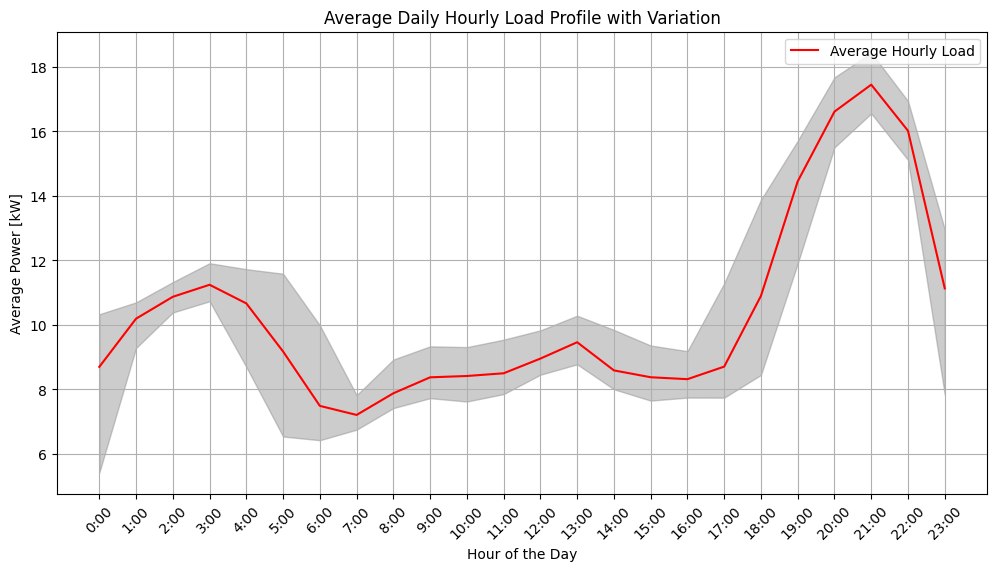

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Profiles_series is a numpy array or similar structure
# Reshape the data for daily and hourly analysis
daily_data = Profiles_series.reshape(num_days, minutes_per_day)
hourly_data = daily_data.reshape(num_days, 24, 60).sum(axis=2) / 60  # Convert to average hourly load

# Compute the mean and the bounds for the shaded area
mean_hourly_profile = np.mean(hourly_data, axis=0) / 1000
max_hourly_profile = np.max(hourly_data, axis=0) / 1000
min_hourly_profile = np.min(hourly_data, axis=0) / 1000

# Plotting the average hourly profile with a cloud of variation
plt.figure(figsize=(12, 6))
plt.plot(mean_hourly_profile, label='Average Hourly Load', color='red')
plt.fill_between(range(24), min_hourly_profile, max_hourly_profile, color='grey', alpha=0.4)
plt.title('Average Daily Hourly Load Profile with Variation')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Power [kW]')
plt.xticks(ticks=range(0, 24), labels=[f"{hour}:00" for hour in range(24)], rotation=45)
plt.grid(True)
plt.legend()
plt.show()

## Exporting the Results

The code block below handles the export of simulation results to Excel. It formats and saves the daily and concatenated load profiles for further analysis and reporting. Execute the code snippet below to export the simulation results, including daily load profiles and average daily load, into an Excel file named 'Load demand results.xlsx', located in the 'Jupyter Notebooks/Results' folder.

In [74]:
import pandas as pd
def export_profiles_to_excel(Profiles_series, Profiles_daily_avg, file_name='Results/Load demand results.xlsx'):
    
    if num_days != 365:
        print(f"WARNING: The number of daily profiles simulated is NOT 365 but {num_days}!") 
        print("The hourly output file will be created but might not be suitable for further modelling purposes.")

    # Creating a pandas DataFrame for the average daily load profile
    avg_profile_df = pd.DataFrame(Profiles_daily_avg, columns=['Average Daily Load (W)'])
    avg_profile_df.index.name = 'Minute of the Day'
    
    # Creating a pandas DataFrame for 1-minute data
    # Transpose the array to have minutes as rows and profiles (days) as columns
    concatenated_profiles_df = pd.DataFrame(Profiles_reshaped.T)
    concatenated_profiles_df.columns = [f'Profile {i+1}' for i in range(num_days)]
    concatenated_profiles_df.index.name = 'Minute'

    # Creating a DataFrame for hourly data
    # Sum the minutes into hours and convert to Wh
    # Reshape and sum the minutes into hours, and convert to Wh, then flatten into a single column
    hourly_data = Profiles_reshaped.reshape(-1, 24, 60).sum(axis=2) / 60
    hourly_flat = hourly_data.flatten()  # Flatten into a single column
    
    # Create a DataFrame for hourly data
    hourly_profiles_df = pd.DataFrame()
    hourly_profiles_df['Hour Index'] = range(0, num_days*24)
    hourly_profiles_df['Hourly Load (Wh)'] = hourly_flat


    # Creating a Pandas Excel writer using openpyxl as the engine
    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        # Writing each DataFrame to a specific sheet
        avg_profile_df.to_excel(writer, sheet_name='Average Daily Profile')
        concatenated_profiles_df.to_excel(writer, sheet_name='Concatenated Profiles')
        hourly_profiles_df.to_excel(writer, sheet_name='Hourly Profiles', index=False)

    print("Data successfully exported to " + file_name)

# Export the results in the "results.xlsx" file into the specified folder
print("Exporting results data in excel....")
export_profiles_to_excel(Profiles_series, Profiles_daily_avg)

Data successfully exported to Results/Load demand results.xlsx
